上一节的高斯核做了这样的操作：
给定 query (即公式中的 $x$)
对数据的 key (公式中的 $x_i$) 与 query 建模，并经过 softmax 运算，得到与 key 对应的 value (即公式中的 $y_i$)的注意力权重。
最后，注意力汇聚的输出就是$\sum \alpha(x,x_i) y_i$
### 总之，当某个 key($x_i$) 与 query($x$) 越接近时，给对应的 value($y_i$) 一个更大的权重

如何给 value 赋权重？就是接下来讨论的两种注意力评分函数。
1. 加性注意力（additive attention）
2. 缩放点积注意力（scaled dot-product attention）

还有一个关键点是**数据尺寸**问题，留心一批有多少个数据(batch_size)、每个数据的实际 shape 大小

In [29]:
import math
import torch
from torch import nn
from d2l import torch as d2l

### (1) 掩蔽softmax操作
任何超出有效长度的位置都被掩蔽并置为0

In [30]:
#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [31]:
# 实例：由两个矩阵表示的样本， 这两个样本的有效长度分别为2和3。 经过掩蔽softmax操作，超出有效长度的值都被掩蔽为0。
r = torch.rand(2, 2, 4)
r

tensor([[[0.7320, 0.0196, 0.0393, 0.1537],
         [0.3835, 0.5864, 0.3973, 0.6456]],

        [[0.6439, 0.1079, 0.5091, 0.5048],
         [0.3220, 0.4608, 0.5462, 0.2843]]])

In [32]:
masked_softmax(r, torch.tensor([2, 3]))

tensor([[[0.6709, 0.3291, 0.0000, 0.0000],
         [0.4495, 0.5505, 0.0000, 0.0000]],

        [[0.4067, 0.2379, 0.3554, 0.0000],
         [0.2941, 0.3379, 0.3680, 0.0000]]])

r[0]只保留前2列，r[1]只保留前3列

也可以使用二维张量，为矩阵样本中的每一行指定有效长度

In [33]:
masked_softmax(r, torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4495, 0.5505, 0.0000, 0.0000]],

        [[0.6309, 0.3691, 0.0000, 0.0000],
         [0.2941, 0.3379, 0.3680, 0.0000]]])

## 2. 加性注意力(additive attention)
当查询和键是不同长度的矢量时，可以使用加性注意力作为评分函数。

其中可学习的参数是$W_q \in \mathbb{R}^{h \times q}$、$W_k \in \mathbb{R}^{h \times k}$和 $w_v \in \mathbb{R}^{h}$。将查询和键连结起来后输入到一个单隐藏层的多层感知机（MLP）中，其隐藏单元数是一个超参数$h$,输出单元数为$1$。 通过使用 $tanh$ 作为激活函数，并且禁用偏置项

In [34]:
#@save
class AdditiveAttention(nn.Module):
    """加性注意力"""

    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    # valid_lens 指定需要多少个 k-v 对
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在使用unsqueeze()扩展维度后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)  # x.unsqueeze(dim) 在 x 的第 dim 个维度上添加一个维度
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        #   features 的形状：                   (batch_size，查询的个数，“键-值”对的个数,num_hidden)
        #   w_v(features) 的形状：              (batch_size，查询的个数，“键-值”对的个数,1)
        #   w_v(features).squeeze(-1) 的形状：  (batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)

        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values) # dropout 丢掉部分 kv 对

一个实例演示

In [38]:
# queries:  一个 batch 里有 2 条子序列,每条子序列里有 1 个 query ,每条 query 长度为 20
# keys:     一个 batch 里有 2 条子序列,每条子序列里有 10 个 key ,每条 key 长度为 2
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1) # values.shape = (2,10,4)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval() # 模型会切换到推理模式，此时梯度计算与参数更新将被禁用，仅前向传播计算输出。好处是可以加快推断过程的速度，并却表结果的一致性
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

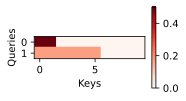

In [39]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

注意 `valid_lens` =(2,6)

## 3. 缩放点积注意力
点积要求查询$q$和键$k$具有相同的长度$d$ (注意是每个数据的长度，而非多少个数据)
例如基于 $n$ 个查询和 $m$ 个键－值对计算注意力，$n,m$ 是任意两个数。查询和键的长度为$d$，值的长度为$v$。
查询$Q \in \mathbb{R}^{n \times d}$、键 $K \in \mathbb{R}^{m \times d}$、值$V \in \mathbb{R}^{m \times v}$
的缩放点积注意力是：
$$softmax(\frac{QK^T}{\sqrt{d}}) V  \in \mathbb{R}{n \times v}$$
下面的缩放点积注意力的实现使用了暂退法进行模型正则化

In [ ]:
#@save
class DotProductAttention(nn.Module):
    """缩放点积注意力"""

    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

为了演示上述的DotProductAttention类， 我们使用与先前加性注意力例子中相同的键、值和有效长度。 对于点积操作，我们令查询的特征维度与键的特征维度大小相同。

In [ ]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

## 总结
- 注意力分数是query和key的相以度，注意力权重是分数的 softmax 结果
- 两种常见的分数计算：
  - 将query和key合并起来进入一个单输出单隐藏层的MLP
  - 直接将 query 和 key 做内积

### ※关于 torch.unsqueeze(input, dim)

In [25]:
# 创建一个形状为 (3, 4) 的二维张量
input = torch.tensor([[1, 2, 3, 4],
                      [5, 6, 7, 8],
                      [9, 10, 11, 12]])

# 在维度1上插入一个新的维度
output = torch.unsqueeze(input, dim=1)
output
# 输出: torch.Size([3, 1, 4])

tensor([[[ 1,  2,  3,  4]],

        [[ 5,  6,  7,  8]],

        [[ 9, 10, 11, 12]]])

In [27]:
# 创建一个形状为 (5,) 的一维张量
input = torch.tensor([1, 2, 3, 4, 5])

output0 = torch.unsqueeze(input, dim=0)  # 在维度 0 上插入一个新的维度
output1 = torch.unsqueeze(input, dim=1)  # 在维度 1 上插入一个新的维度

output0, output1
# 输出: torch.Size([1, 5])

(tensor([[1, 2, 3, 4, 5]]),
 tensor([[1],
         [2],
         [3],
         [4],
         [5]]))

## QA
1. 核回归里面算法后面的那个红色的热图是什么意思？
>  表示给定 query 后，每个 kv 对的注意力权重。与 q 越相近的$k_i$,其$k_i,v_i$越红

2. 为什么注意力分数可以理解为二者的相似度？
> 只是通常用相似度来衡量注意力分数

3. masked_softmax()就相当于把注意力分数低的过滤掉吗？
> masked_softmax() 不是过滤低分注意力kv对。只是将之前（为了张量间长度保持一致）产生的无意义的占位元素再次去掉